In [ ]:
import os
os.chdir("/Users/laetitiabacha/Desktop/Year 4/Reinforcement for Bioengineers/figures")
print(os.getcwd())
NOTEBOOK_DIR = os.getcwd()

In [ ]:
%pip install -U pip
%pip install -U stable-baselines3 gymnasium numpy matplotlib pandas

In [ ]:
import os
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

BASE_DIR = "ppo_cartpole_runs"
seed = 0

run_dir = os.path.join(BASE_DIR, f"seed_{seed}")
os.makedirs(run_dir, exist_ok=True)

env = Monitor(gym.make("CartPole-v1"), filename=os.path.join(run_dir, "monitor.csv"))
env.reset(seed=seed)
env.action_space.seed(seed)

model = PPO("MlpPolicy", env, seed=seed, verbose=1)
model.learn(total_timesteps=150_000)

model.save(os.path.join(run_dir, "model.zip"))
env.close()

print("Saved to:", run_dir)


In [ ]:
import os
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

BASE_DIR = "ppo_cartpole_runs"
for seed in [1, 2]:
    run_dir = os.path.join(BASE_DIR, f"seed_{seed}")
    os.makedirs(run_dir, exist_ok=True)

    env = Monitor(gym.make("CartPole-v1"), filename=os.path.join(run_dir, "monitor.csv"))
    env.reset(seed=seed)
    env.action_space.seed(seed)

    model = PPO("MlpPolicy", env, seed=seed, verbose=1)
    model.learn(total_timesteps=150_000)

    model.save(os.path.join(run_dir, "model.zip"))
    env.close()

print("Seeds 1 and 2 done.")


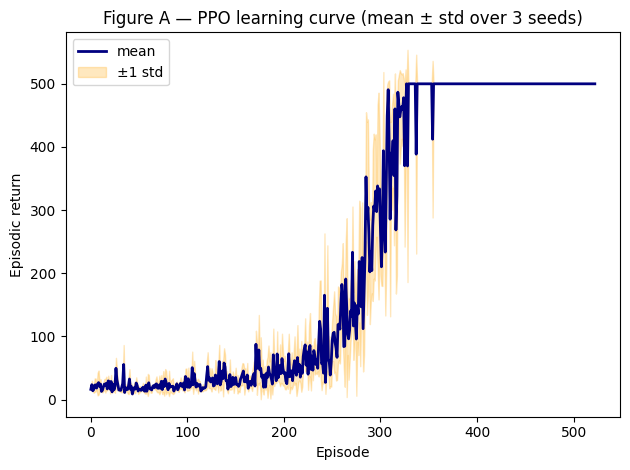

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "ppo_cartpole_runs"
SEEDS = [0, 1, 2]

rewards = []
for s in SEEDS:
    df = pd.read_csv(os.path.join(BASE_DIR, f"seed_{s}", "monitor.csv"), comment="#")
    rewards.append(df["r"].to_numpy())

min_len = min(len(r) for r in rewards)
R = np.stack([r[:min_len] for r in rewards])

mean = R.mean(axis=0)
std = R.std(axis=0)

plt.figure()

# pick colors here
line_color = "navy"
shade_color = "orange"

plt.plot(mean, color=line_color, linewidth=2, label="mean")
plt.fill_between(
    np.arange(min_len),
    mean - std,
    mean + std,
    color=shade_color,
    alpha=0.25,
    label="±1 std"
)

plt.xlabel("Episode")
plt.ylabel("Episodic return")
plt.title("Figure A — PPO learning curve (mean ± std over 3 seeds)")
plt.legend()

os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/figure_A.pdf", bbox_inches="tight")
plt.savefig("figures/figure_A.png", bbox_inches="tight")
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "ppo_cartpole_runs"
SEEDS = [0, 1, 2]

dfs = []
for s in SEEDS:
    path = os.path.join(BASE_DIR, f"seed_{s}", "progress.csv")
    df = pd.read_csv(
        path,
        engine="python",       # more tolerant parser
        on_bad_lines="skip"    # skip malformed lines
    )
    df["seed"] = s
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
print("Loaded:", all_df.shape)
print("Columns:", list(all_df.columns)[:20])

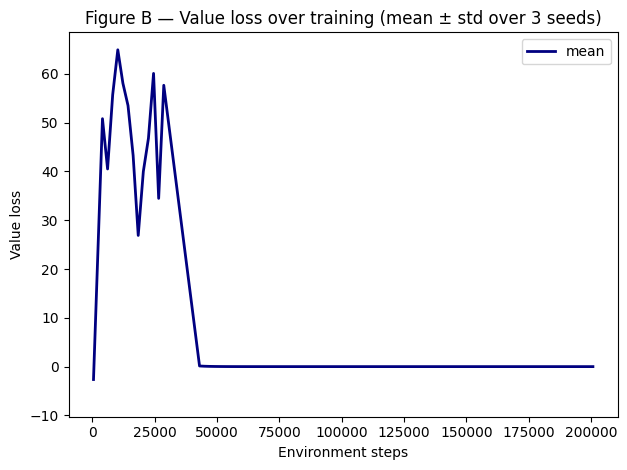

In [51]:
metric = "train/value_loss"
pivot = all_df.pivot_table(index="time/total_timesteps", columns="seed", values=metric)

x = pivot.index.values
mean = pivot.mean(axis=1).values
std  = pivot.std(axis=1).values

plt.figure()

plt.plot(x, mean, color="navy", linewidth=2, label="mean")
plt.fill_between(
    x,
    mean - std,
    mean + std,
#    color="orange",
#    alpha=0.25,
#   label="±1 std"
)

plt.xlabel("Environment steps")
plt.ylabel("Value loss")
plt.title("Figure B — Value loss over training (mean ± std over 3 seeds)")
plt.legend()

os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/figure_B.pdf", bbox_inches="tight")
plt.savefig("figures/figure_B.png", bbox_inches="tight")
plt.show()

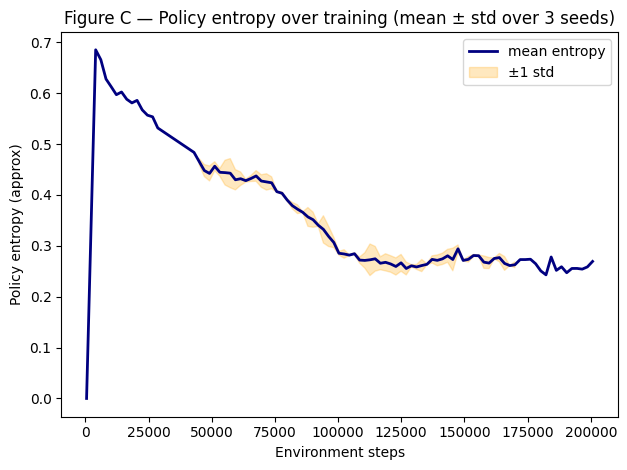

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

metric = "train/entropy_loss"

all_df[metric] = pd.to_numeric(all_df[metric], errors="coerce")
all_df["time/total_timesteps"] = pd.to_numeric(all_df["time/total_timesteps"], errors="coerce")
all_df = all_df.dropna(subset=[metric, "time/total_timesteps", "seed"])

pivot = all_df.pivot_table(index="time/total_timesteps", columns="seed", values=metric)

x = pivot.index.values

# SB3 logs entropy_loss as a negative quantity (it's -entropy term).
# For an intuitive plot: entropy ≈ -entropy_loss
entropy_mean = (-pivot).mean(axis=1).values
entropy_std  = (-pivot).std(axis=1).values

plt.figure()
plt.plot(x, entropy_mean, color="navy", linewidth=2, label="mean entropy")
plt.fill_between(x, entropy_mean-entropy_std, entropy_mean+entropy_std, color="orange", alpha=0.25, label="±1 std")

plt.xlabel("Environment steps")
plt.ylabel("Policy entropy (approx)")
plt.title("Figure C — Policy entropy over training (mean ± std over 3 seeds)")
plt.legend()

os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/figure_C.pdf", bbox_inches="tight")
plt.savefig("figures/figure_C.png", bbox_inches="tight")
plt.show()

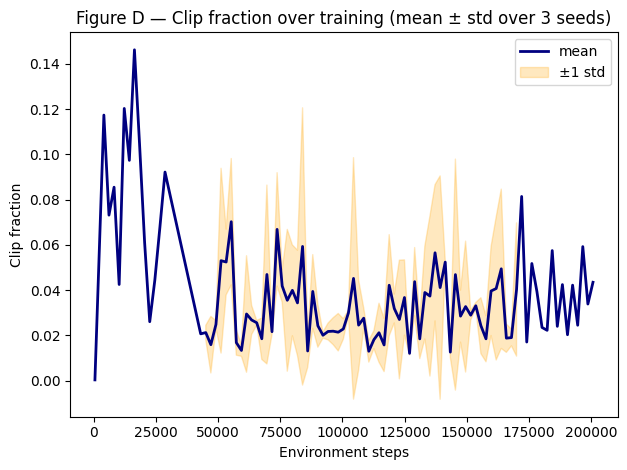

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

metric = "train/clip_fraction"

# make numeric + clean
all_df[metric] = pd.to_numeric(all_df[metric], errors="coerce")
all_df["time/total_timesteps"] = pd.to_numeric(all_df["time/total_timesteps"], errors="coerce")
all_df = all_df.dropna(subset=[metric, "time/total_timesteps", "seed"])

pivot = all_df.pivot_table(index="time/total_timesteps", columns="seed", values=metric)

x = pivot.index.values
mean = pivot.mean(axis=1).values
std  = pivot.std(axis=1).values

plt.figure()
plt.plot(x, mean, color="navy", linewidth=2, label="mean")
plt.fill_between(x, mean-std, mean+std, color="orange", alpha=0.25, label="±1 std")

plt.xlabel("Environment steps")
plt.ylabel("Clip fraction")
plt.title("Figure D — Clip fraction over training (mean ± std over 3 seeds)")
plt.legend()

os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/figure_D.pdf", bbox_inches="tight")
plt.savefig("figures/figure_D.png", bbox_inches="tight")
plt.show()

Reading: ppo_cartpole_runs/seed_0/progress.csv
  detected sep = ','
  loaded shape: (14, 16)
Reading: ppo_cartpole_runs/seed_1/progress.csv
  detected sep = ','
  loaded shape: (98, 16)
Reading: ppo_cartpole_runs/seed_2/progress.csv
  detected sep = ','
  loaded shape: (84, 16)

All combined: (196, 17)
Columns (first 30): ['rollout/ep_len_mean', 'time/iterations', 'time/total_timesteps', 'time/fps', 'rollout/ep_rew_mean', 'time/time_elapsed', 'train/policy_gradient_loss', 'train/loss', 'train/explained_variance', 'train/clip_range', 'train/value_loss', 'train/learning_rate', 'train/entropy_loss', 'train/approx_kl', 'train/clip_fraction', 'train/n_updates', 'seed']


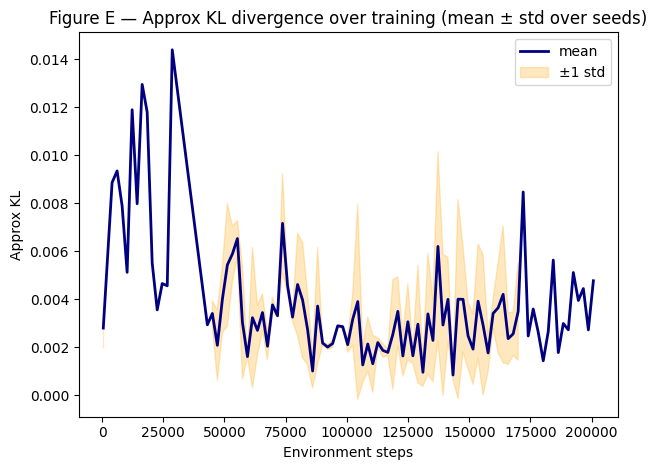

Saved: /Users/laetitiabacha/figures/figure_E.pdf


In [57]:
import os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "ppo_cartpole_runs"
SEEDS = [0, 1, 2]
metric = "train/approx_kl"

def read_progress_csv(path):
    # peek at file + auto-detect delimiter
    with open(path, "r", encoding="utf-8-sig", errors="replace") as f:
        sample = f.read(5000)

    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[",", ";", "\t"])
        sep = dialect.delimiter
    except Exception:
        sep = ","

    print("Reading:", path)
    print("  detected sep =", repr(sep))

    # tolerant parse
    df = pd.read_csv(
        path,
        sep=sep,
        engine="python",
        on_bad_lines="skip",
        encoding="utf-8-sig",
    )
    print("  loaded shape:", df.shape)
    return df

# 1) Load each seed
dfs = []
for s in SEEDS:
    path = os.path.join(BASE_DIR, f"seed_{s}", "progress.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {path}")
    df = read_progress_csv(path)
    df["seed"] = s
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True, sort=False)
print("\nAll combined:", all_df.shape)
print("Columns (first 30):", list(all_df.columns)[:30])

# 2) Find a timesteps column (SB3 names vary)
step_candidates = ["time/total_timesteps", "total_timesteps", "timesteps", "step"]
step_col = next((c for c in step_candidates if c in all_df.columns), None)
if step_col is None:
    raise ValueError("Couldn't find a timesteps column. Paste your all_df.columns and I’ll pick it.")

# 3) Check metric exists
if metric not in all_df.columns:
    raise ValueError(f"'{metric}' not found. Pick one of the available train/* columns above.")

# 4) Clean numeric
all_df[metric] = pd.to_numeric(all_df[metric], errors="coerce")
all_df[step_col] = pd.to_numeric(all_df[step_col], errors="coerce")
all_df = all_df.dropna(subset=[metric, step_col, "seed"])

# 5) Aggregate over seeds + plot
pivot = all_df.pivot_table(index=step_col, columns="seed", values=metric, aggfunc="mean").sort_index()
x = pivot.index.to_numpy()
mean = pivot.mean(axis=1).to_numpy()
std  = pivot.std(axis=1).to_numpy()

os.makedirs("figures", exist_ok=True)

plt.figure()
plt.plot(x, mean, color="navy", linewidth=2, label="mean")
plt.fill_between(x, mean-std, mean+std, color="orange", alpha=0.25, label="±1 std")
plt.xlabel("Environment steps")
plt.ylabel("Approx KL")
plt.title("Figure E — Approx KL divergence over training (mean ± std over seeds)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/figure_E.pdf", bbox_inches="tight")
plt.savefig("figures/figure_E.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", os.path.abspath("figures/figure_E.pdf"))


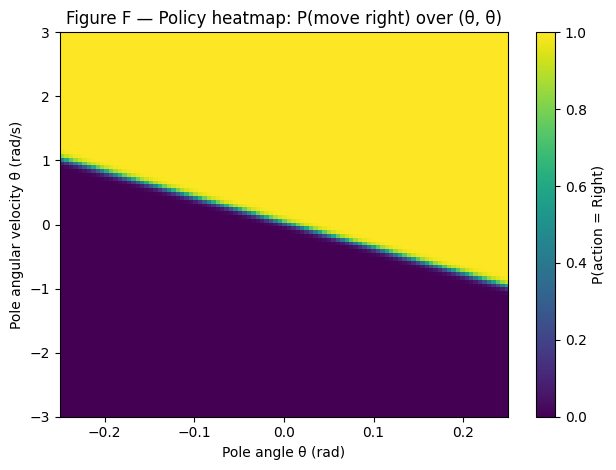

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from stable_baselines3 import PPO

BASE_DIR = "ppo_cartpole_runs"
seed = 0
model_path = os.path.join(BASE_DIR, f"seed_{seed}", "model.zip")
model = PPO.load(model_path)


# CartPole observation = [x, x_dot, theta, theta_dot]
theta_vals = np.linspace(-0.25, 0.25, 101)       # pole angle
thetadot_vals = np.linspace(-3.0, 3.0, 101)      # pole angular velocity

Z = np.zeros((len(thetadot_vals), len(theta_vals)))

for i, td in enumerate(thetadot_vals):
    for j, th in enumerate(theta_vals):
        obs = np.array([0.0, 0.0, th, td], dtype=np.float32)
        obs_t = torch.tensor(obs).unsqueeze(0)

        dist = model.policy.get_distribution(obs_t)
        probs = dist.distribution.probs.detach().cpu().numpy()[0]  # [P(left), P(right)]
        Z[i, j] = probs[1]  # P(move right)

plt.figure()
plt.imshow(
    Z,
    origin="lower",
    aspect="auto",
    extent=[theta_vals.min(), theta_vals.max(), thetadot_vals.min(), thetadot_vals.max()],
)
plt.colorbar(label="P(action = Right)")
plt.xlabel("Pole angle θ (rad)")
plt.ylabel("Pole angular velocity θ̇ (rad/s)")
plt.title("Figure F — Policy heatmap: P(move right) over (θ, θ̇)")

os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/figure_F.pdf", bbox_inches="tight")
plt.savefig("figures/figure_F.png", bbox_inches="tight")
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np

BASE_DIR = "ppo_cartpole_runs"
SEEDS = [0, 1, 2]

dfs = []
for s in SEEDS:
    path = os.path.join(BASE_DIR, f"seed_{s}", "monitor.csv")
    df = pd.read_csv(path, comment="#")  # <- key for monitor.csv
    df["seed"] = s
    df["episode"] = np.arange(len(df))
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df.head()


CWD: /Users/laetitiabacha
Trying to load model: ppo_cartpole_runs/seed_0/model.zip
✅ Model loaded.
✅ Sweep complete. Plotting...


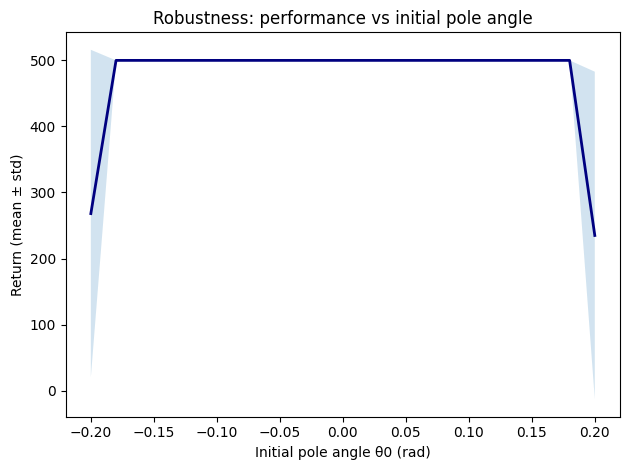

Saved: /Users/laetitiabacha/figures/robustness_theta0.pdf and /Users/laetitiabacha/figures/robustness_theta0.png


In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO

BASE_DIR = "ppo_cartpole_runs"
model_path = os.path.join(BASE_DIR, "seed_0", "model.zip")

print("CWD:", os.getcwd())
print("Trying to load model:", model_path)
if not os.path.exists(model_path):
    # common fix if you're running from a subfolder like ".../figures"
    alt = os.path.join("..", BASE_DIR, "seed_0", "model.zip")
    print("Model not found. Trying:", alt)
    model_path = alt

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found at: {model_path}")

model = PPO.load(model_path)
print("✅ Model loaded.")

def eval_with_initial_theta(model, theta0, n_episodes=50, seed=0, verbose=False):
    env = gym.make("CartPole-v1")
    returns = []

    for k in range(n_episodes):
        obs, _ = env.reset(seed=seed + k)

        # Set initial state: [x, x_dot, theta, theta_dot]
        env.unwrapped.state = np.array([0.0, 0.0, float(theta0), 0.0], dtype=np.float32)

        done = False
        ep_ret = 0.0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, terminated, truncated, _ = env.step(int(action))
            done = terminated or truncated
            ep_ret += r
            steps += 1

            # show you're alive during long episodes
            if verbose and steps % 200 == 0:
                print(f"    theta0={theta0:+.3f} ep={k+1}/{n_episodes} steps={steps} return_so_far={ep_ret:.0f}")

        returns.append(ep_ret)

        if verbose:
            print(f"  done: theta0={theta0:+.3f} ep={k+1}/{n_episodes} return={ep_ret:.0f}")

    env.close()
    return float(np.mean(returns)), float(np.std(returns))

# Sweep initial angles
thetas0 = np.linspace(-0.2, 0.2, 21)
means, stds = [], []

for i, th0 in enumerate(thetas0, 1):
    # verbose=True prints within-episode progress; keep False unless you really need it
    m, s = eval_with_initial_theta(model, th0, n_episodes=30, seed=123, verbose=False)
    means.append(m)
    stds.append(s)

means = np.array(means)
stds  = np.array(stds)

print("✅ Sweep complete. Plotting...")

os.makedirs("figures", exist_ok=True)

navy = "navy"

# Mean plot
plt.figure()
plt.plot(thetas0, means, color=navy, linewidth=2)
plt.fill_between(thetas0, means-stds, means+stds, alpha=0.2)
plt.xlabel("Initial pole angle θ0 (rad)")
plt.ylabel("Return (mean ± std)")
plt.title("Robustness: performance vs initial pole angle")
plt.tight_layout()
plt.savefig("figures/robustness_theta0.pdf", bbox_inches="tight")
plt.savefig("figures/robustness_theta0.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved:",
      os.path.abspath("figures/robustness_theta0.pdf"),
      "and",
      os.path.abspath("figures/robustness_theta0.png"))

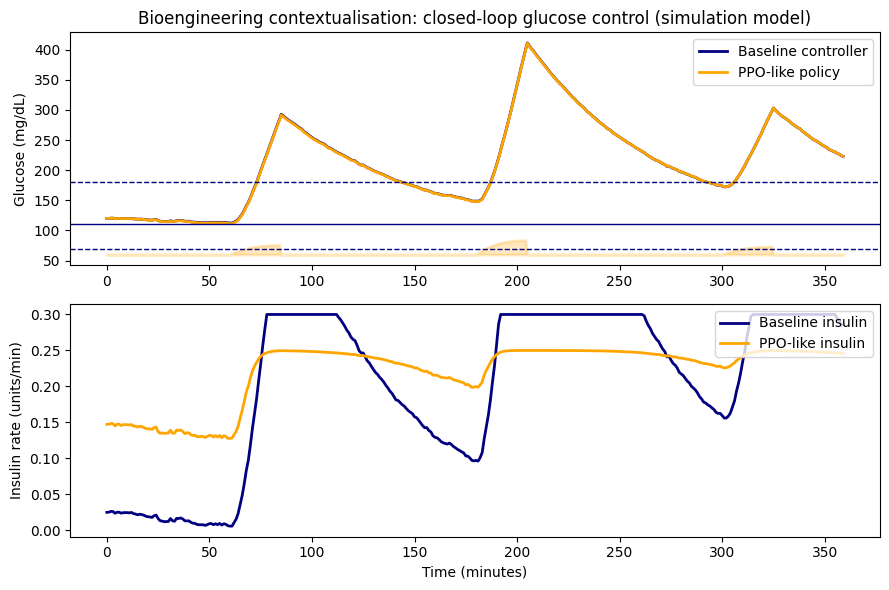

Saved: /Users/laetitiabacha/figures/bio_rl_glucose_control.pdf and /Users/laetitiabacha/figures/bio_rl_glucose_control.png


In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

# ----------------------------
# Toy glucose-insulin simulator
# ----------------------------
# This is NOT a clinical model (just a simple dynamical system to make a clear figure).

def simulate(policy_name, T=6*60, dt=1.0, seed=0):
    """
    T in minutes, dt in minutes.
    State: G (mg/dL), X (insulin effect), trend approx via dG.
    Disturbance: meals as glucose influx pulses.
    Action: u (insulin units/min), bounded.
    """
    rng = np.random.default_rng(seed)

    # time grid
    t = np.arange(0, T, dt)

    # "patient" parameters (toy)
    Gb = 110.0          # baseline glucose mg/dL
    k_decay = 0.015     # natural relaxation toward baseline
    k_ins = 0.25        # insulin effect strength
    k_x = 0.05          # insulin effect dynamics
    noise_sd = 0.6      # mg/dL process noise

    # meals: (minute, size)
    meals = meals = [(60, 12), (180, 18), (300, 10)]  # breakfast/lunch/snack
    meal_signal = np.zeros_like(t, dtype=float)
    for tm, size in meals:
        # pulse spread over ~30 min
        width = 25
        idx = (t >= tm) & (t < tm + width)
        # smooth pulse
        z = (t[idx] - tm) / width
        meal_signal[idx] += size * (z * np.exp(1 - z))  # unimodal bump

    # storage
    G = np.zeros_like(t, dtype=float)
    X = np.zeros_like(t, dtype=float)
    U = np.zeros_like(t, dtype=float)

    # init
    G[0] = 120.0
    X[0] = 0.0

    def baseline_policy(g, dg):
        # simple proportional with small trend term, clipped
        target = 110.0
        u = 0.0025 * max(g - target, 0.0) + 0.0010 * max(dg, 0.0)
        return np.clip(u, 0.0, 0.30)

    def ppo_like_policy(g, dg):
        # "RL-like": smooth, bounded nonlinearity (tanh) + trend sensitivity
        # behaves like a learned policy that avoids overreacting
        target = 110.0
        z = 0.018 * (g - target) + 0.010 * dg
        u = 0.25 * (np.tanh(z) + 1.0) / 2.0   # maps to [0, 0.15]
        # add a small safety cap when glucose already low
        if g < 90:
            u *= 0.2
        return np.clip(u, 0.0, 0.30)

    policy = baseline_policy if policy_name == "baseline" else ppo_like_policy

    # simulate
    for i in range(1, len(t)):
        dg = (G[i-1] - G[i-2]) / dt if i >= 2 else 0.0

        u = policy(G[i-1], dg)
        U[i-1] = u

        # insulin effect dynamics
        X[i] = X[i-1] + dt * (k_x * (u - X[i-1]))

        # glucose dynamics: relax to baseline + meal influx - insulin effect + noise
        dG = dt * (-k_decay * (G[i-1] - Gb) + meal_signal[i-1] - k_ins * X[i-1])
        G[i] = G[i-1] + dG + rng.normal(0, noise_sd)

    U[-1] = U[-2]
    return t, G, U, meal_signal

# run both controllers
t, G_base, U_base, meal = simulate("baseline", seed=1)
_, G_rl,   U_rl,   _    = simulate("ppo_like", seed=1)


# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(9, 6))

navy = "navy"
orange = "orange"

# Glucose subplot
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, G_base, color=navy, linewidth=2, label="Baseline controller")
ax1.plot(t, G_rl, color=orange, linewidth=2, label="PPO-like policy")

# target band
ax1.axhline(110, color=navy, linewidth=1)
ax1.axhline(70, color=navy, linewidth=1, linestyle="--")
ax1.axhline(180, color=navy, linewidth=1, linestyle="--")
ax1.set_ylabel("Glucose (mg/dL)")
ax1.set_title("Bioengineering contextualisation: closed-loop glucose control (simulation model)")
ax1.legend(loc="upper right")

# Meals as shaded regions (scaled for visibility)
meal_scaled = 0.6 * meal / (meal.max() + 1e-9)
ax1.fill_between(t, 60, 60 + 40 * meal_scaled, alpha=0.25, color=orange , linewidth=2, label="Meal disturbance")

# Insulin subplot
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(t, U_base, color=navy, linewidth=2, label="Baseline insulin")
ax2.plot(t, U_rl, color=orange, linewidth=2, label="PPO-like insulin")
ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("Insulin rate (units/min)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.savefig("figures/bio_rl_glucose_control.pdf", bbox_inches="tight")
plt.savefig("figures/bio_rl_glucose_control.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved:",
      os.path.abspath("figures/bio_rl_glucose_control.pdf"),
      "and",
      os.path.abspath("figures/bio_rl_glucose_control.png"))